## INITIAL SETUP

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt


In [5]:
# load datasets
CLEANED_DATA_PATH = Path.cwd().resolve().parents[1] / "data" / "cleaned"

df_ks = pd.read_csv(CLEANED_DATA_PATH / 'kickstarter_cleaned.csv')

df_ks.head()

,id,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,duration_days,target
0,1000002330,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,58,0
1,1000003930,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,59,0
2,1000004038,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,44,0
3,1000007540,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,29,0
4,1000014025,Food,2016-04-01,2016-02-26 13:38:27,successful,224,US,52375.0,50000.00,34,1


# EDA
## drop NaN value columns
- we dont need pledged column with NaN 

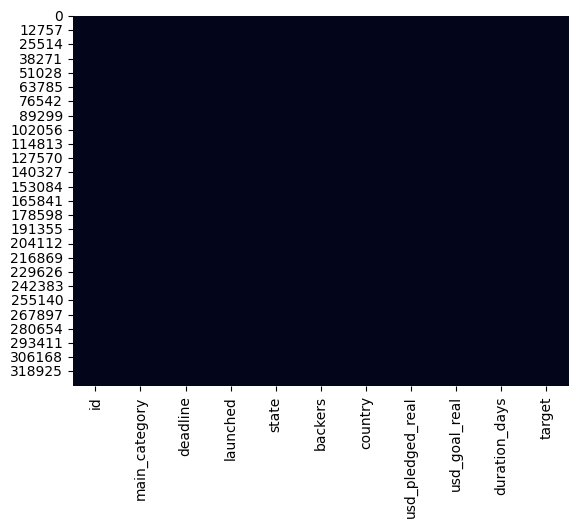

In [ ]:
# show that we dont have missing values

sns.heatmap(df_ks.isna(), cbar=False)
plt.show()

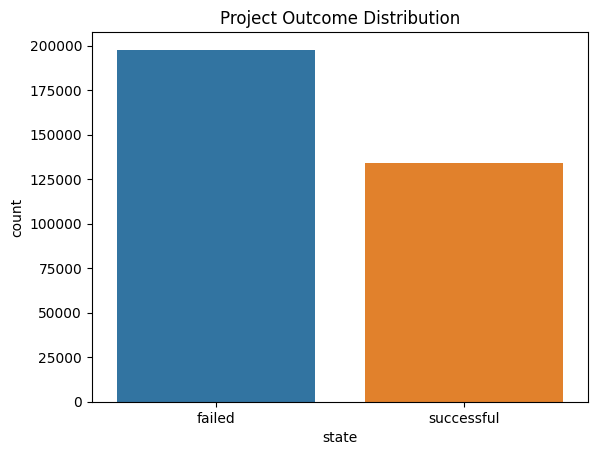

In [12]:
# Check out the distribution of the target variable
sns.countplot(x="state", data=df_ks)
plt.title("Project Outcome Distribution")
plt.show()

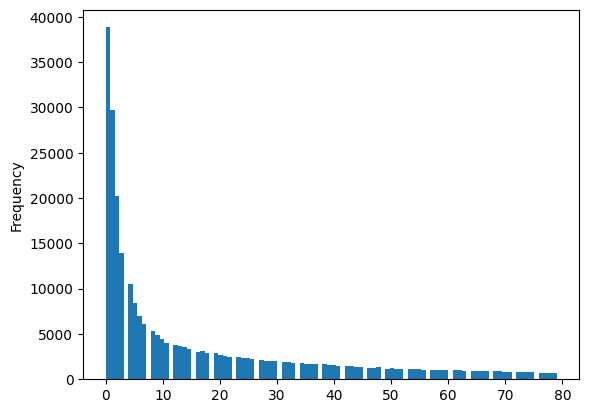

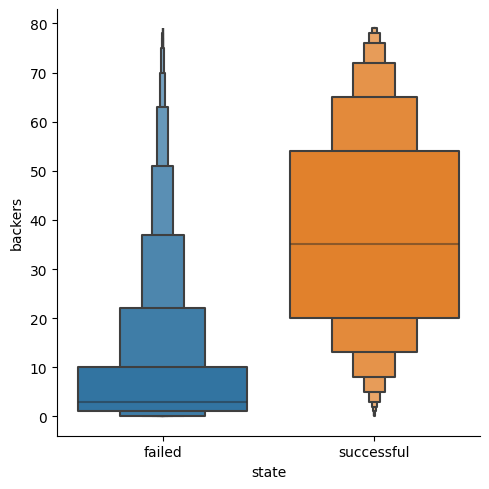

In [13]:
# cutting backers down to see the curve 
df1_test = df_ks.query("backers < 80.000")
df1_test['backers'].plot(kind='hist', bins=100) 

# and check by state: 
sns.catplot(data=df1_test, x="state", y="backers", kind="boxen")

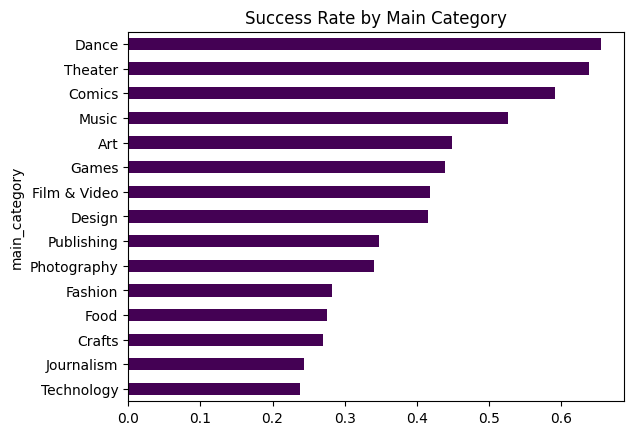

In [33]:
# After we've described the "all numerical curves are not bell curves", we could go into the success rates ones
success_rate = (
    df_ks.assign(success=df_ks["state"] == "successful")
      .groupby("main_category")["success"]
      .mean()
      .sort_values()
)

success_rate.plot(kind="barh", colormap="viridis")
plt.title("Success Rate by Main Category")
plt.show()

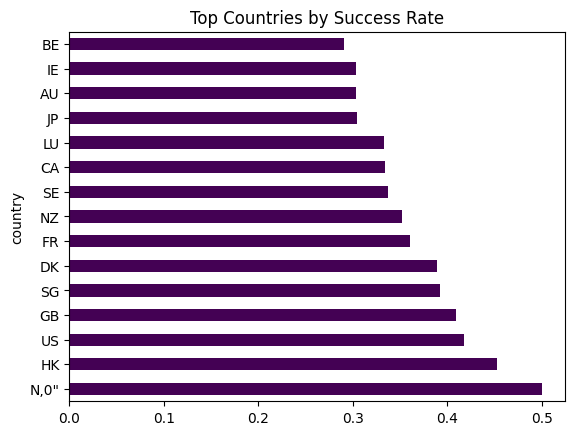

In [36]:
country_success = (
    df_ks.assign(success=df_ks["state"] == "successful")
      .groupby("country")["success"]
      .mean()
      .sort_values(ascending=False)
)

country_success.head(15).plot(kind="barh", colormap="viridis")
plt.title("Top Countries by Success Rate")
plt.show()

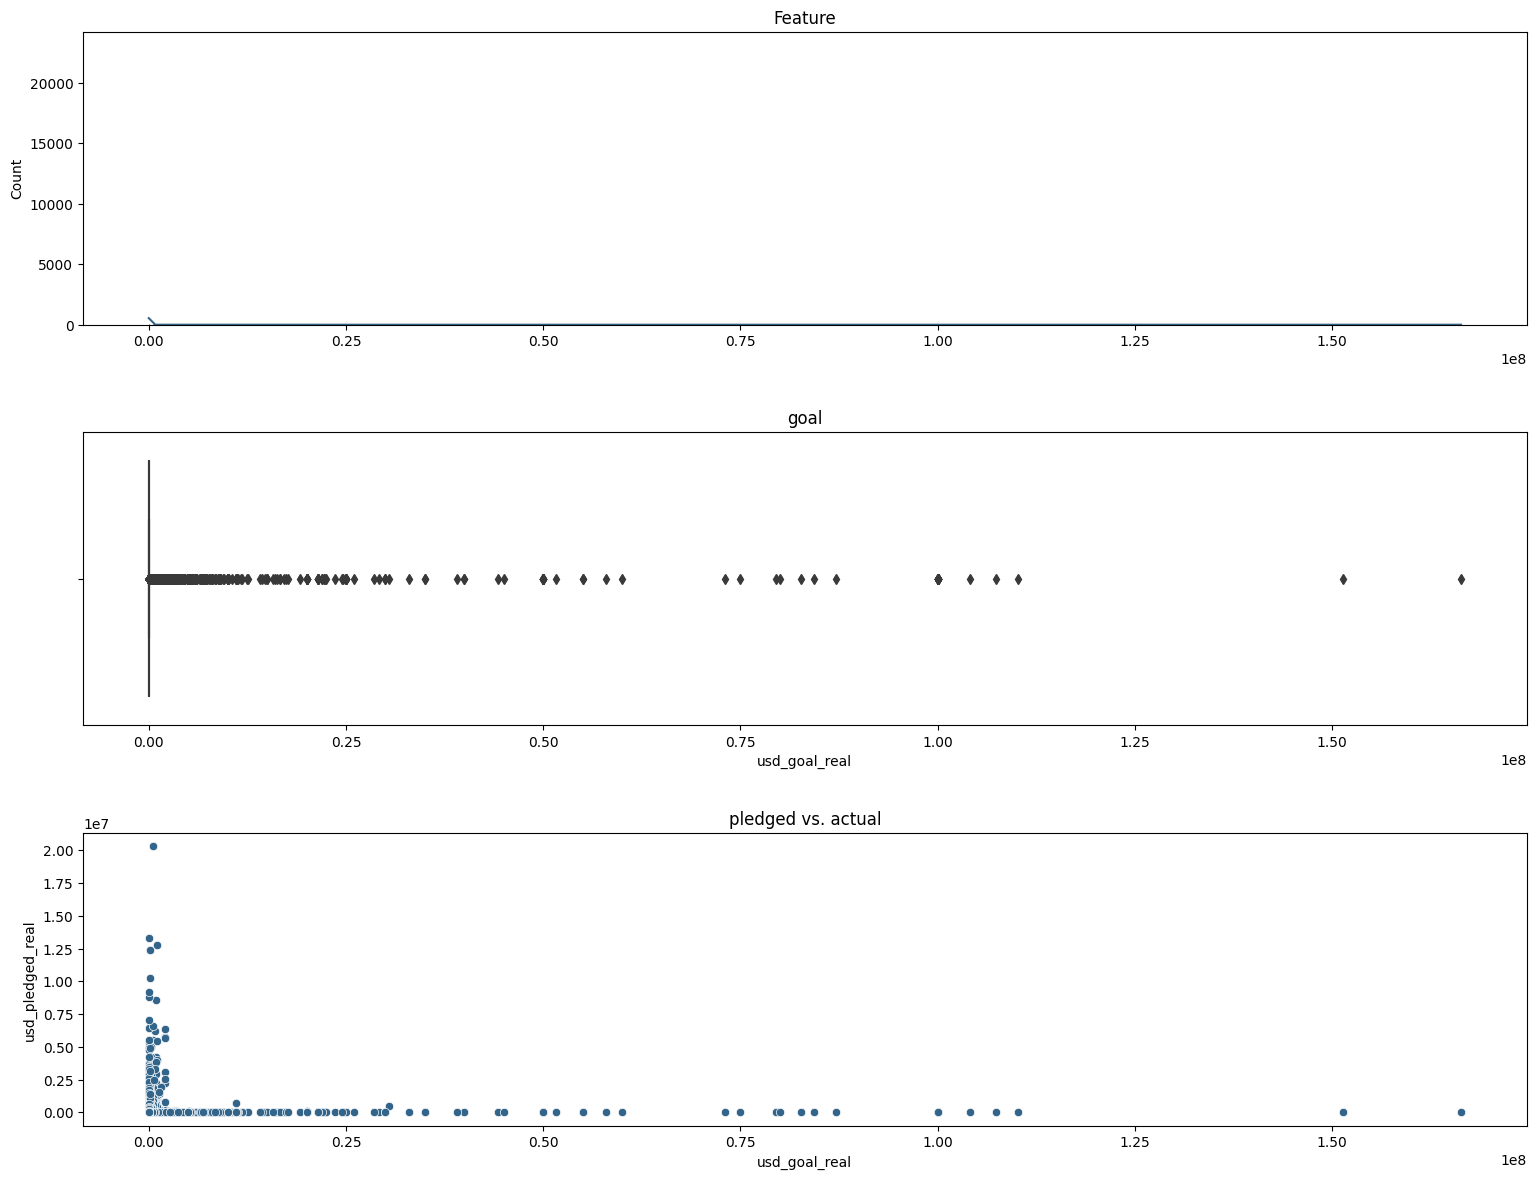

In [17]:
fig, ax = plt.subplots(nrows=4, figsize = (16,16))
count=0
#histogram
sns.histplot(df_ks['usd_goal_real'], kde=True, ax=ax[0], color='#33658A').set(title='Feature', xlabel='')
#boxplot
sns.boxplot(x=df_ks['usd_goal_real'], ax=ax[1], color='#33658A').set(title="goal")
#scatter plot
sns.scatterplot(x=df_ks.usd_goal_real, y=df_ks.usd_pledged_real, ax=ax[2], color='#33658A').set(title='pledged vs. actual')
#cleaning up: 
ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)

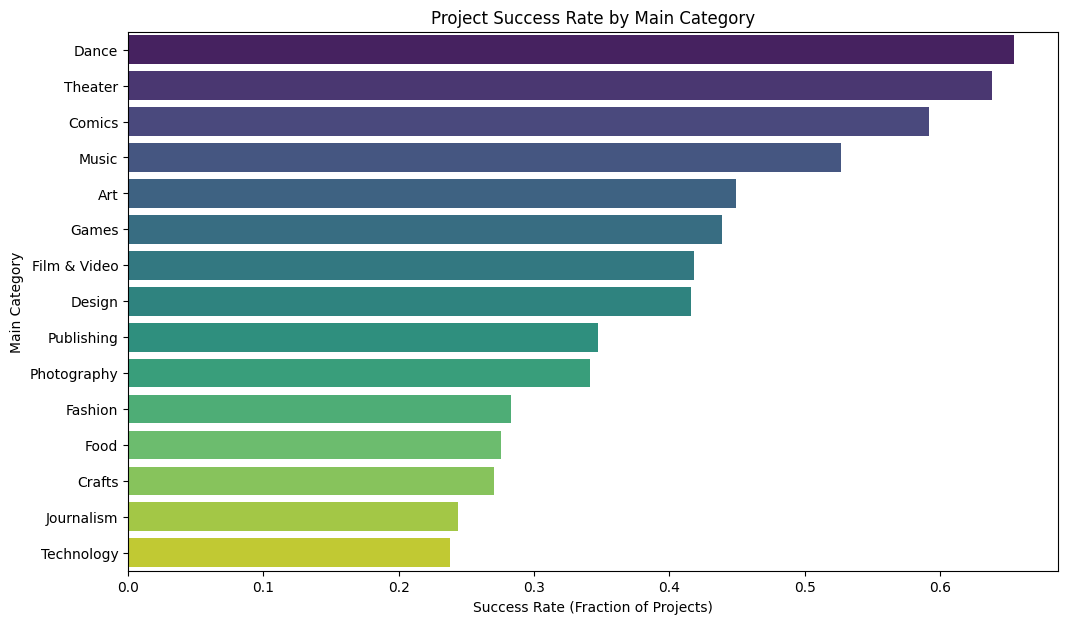

In [30]:
# Filter for only 'successful' and 'failed' states for this analysis (optional but common)
success_fail_df = df_ks[df_ks['state'].isin(['successful', 'failed'])]

# Create a new binary column: 1 if successful, 0 otherwise
success_fail_df['is_successful'] = np.where(success_fail_df['state'] == 'successful', 1, 0)

# Calculate the mean success rate per category
category_success_rate = success_fail_df.groupby('main_category')['is_successful'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 7))
sns.barplot(
    x='is_successful',
    y='main_category',
    data=category_success_rate,
    palette='viridis'
)
plt.title('Project Success Rate by Main Category')
plt.xlabel('Success Rate (Fraction of Projects)')
plt.ylabel('Main Category')
plt.show()

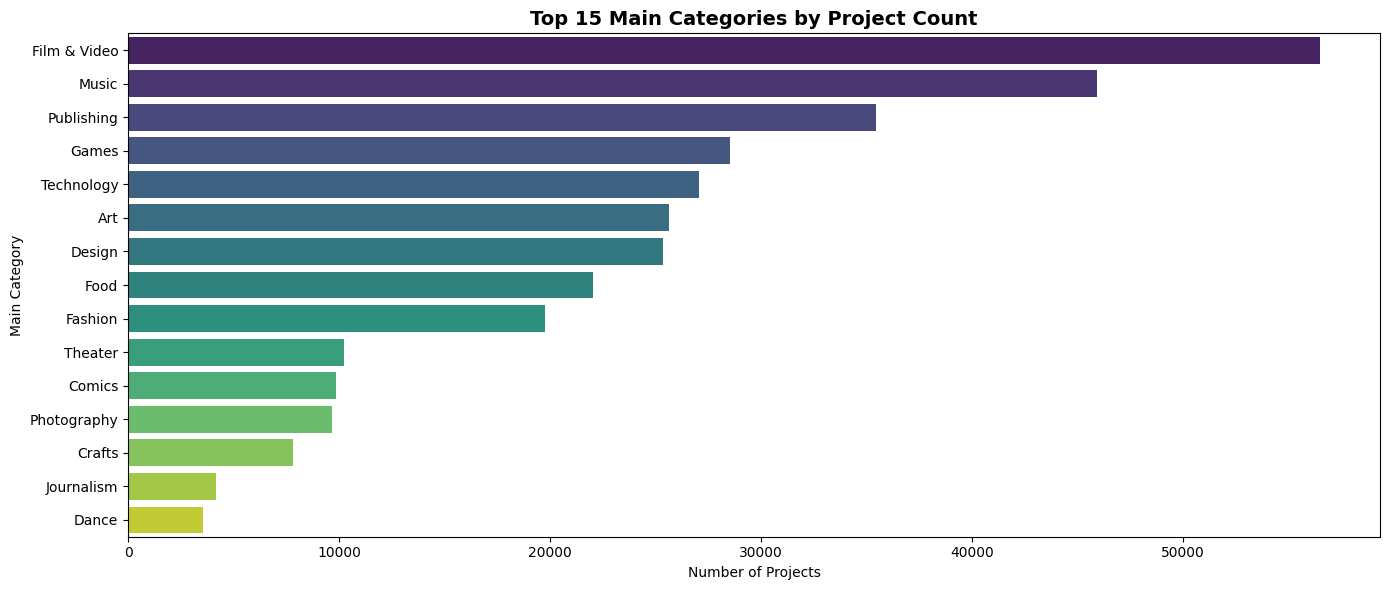

In [19]:
# 2. Main Categories Distribution
plt.figure(figsize=(14, 6))
category_counts = df_ks['main_category'].value_counts().head(15)
sns.barplot(x=category_counts.values, y=category_counts.index, palette='viridis')
plt.title('Top 15 Main Categories by Project Count', fontsize=14, fontweight='bold')
plt.xlabel('Number of Projects')
plt.ylabel('Main Category')
plt.tight_layout()
plt.show()

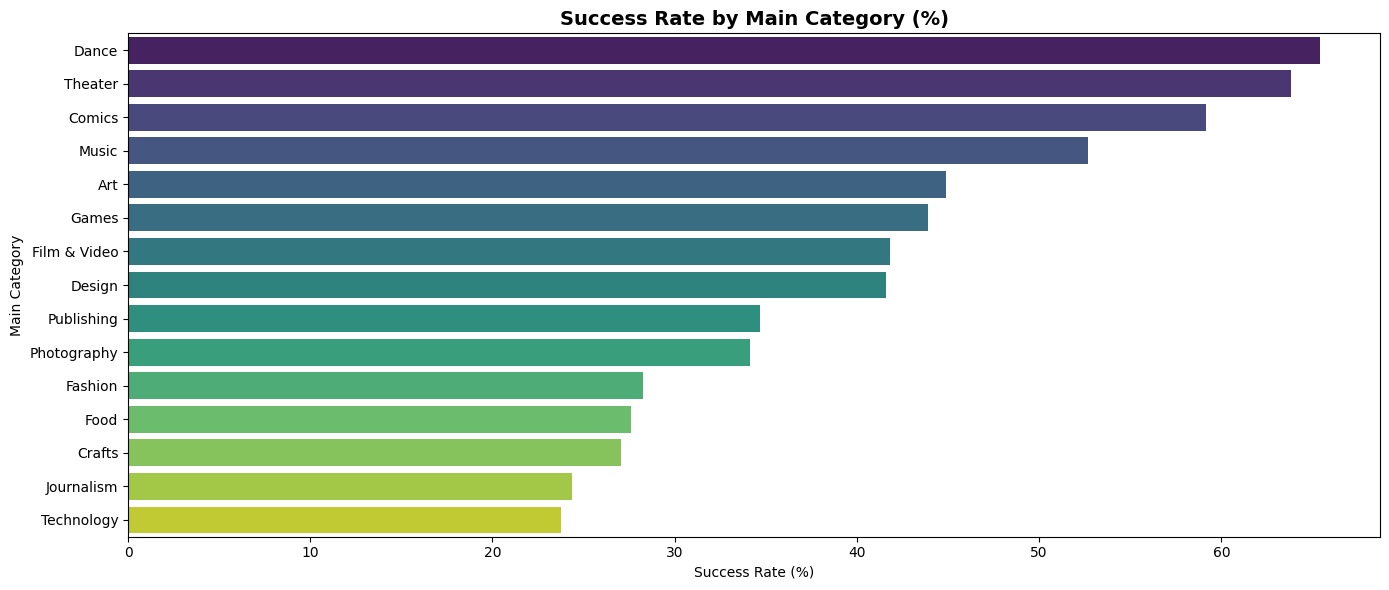

In [29]:
# 3. Success Rate by Main Category
category_success = df_ks.groupby('main_category')['state'].apply(
    lambda x: (x == 'successful').sum() / len(x) * 100
).sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x=category_success.values, y=category_success.index, palette='viridis')
plt.title('Success Rate by Main Category (%)', fontsize=14, fontweight='bold')
plt.xlabel('Success Rate (%)')
plt.ylabel('Main Category')
plt.tight_layout()
plt.show()

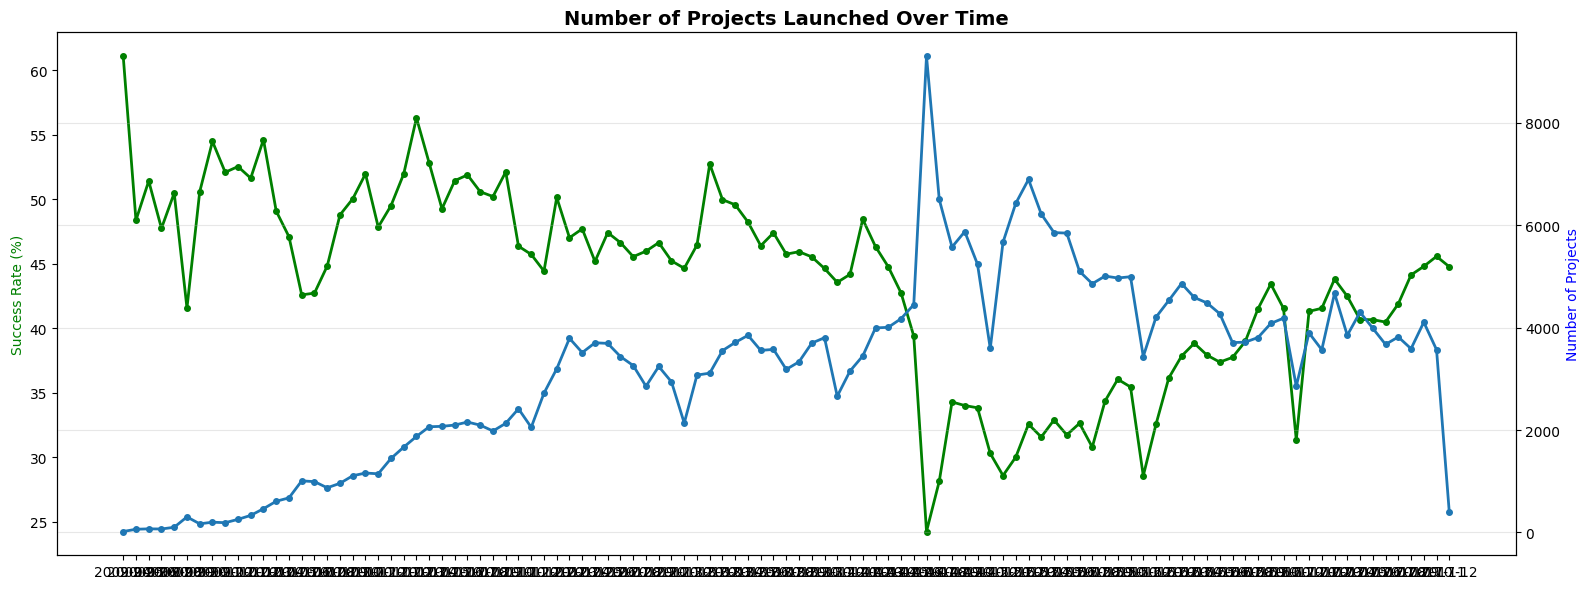

In [26]:
# 6. Projects Launched Over Time
df_ks["launched"] = pd.to_datetime(df_ks["launched"], errors="coerce")
df_ks["deadline"] = pd.to_datetime(df_ks["deadline"], errors="coerce")

df_time = df_ks.dropna(subset=['launched'])
df_time['year_month'] = df_time['launched'].dt.to_period('M')

monthly_counts = df_time['year_month'].value_counts().sort_index()

# 7. Success Rate Over Time
df_time_success = df_time.groupby('year_month')['state'].apply(
    lambda x: (x == 'successful').sum() / len(x) * 100
).sort_index()

fig1, ax1 = plt.subplots(figsize=(16, 6))

ax1.plot(df_time_success.index.astype(str), df_time_success.values, 
         marker='o', linewidth=2, markersize=4, color='green')
ax1.set_ylabel('Success Rate (%)', color='green')
ax2 = ax1.twinx()

ax2.plot(monthly_counts.index.astype(str), monthly_counts.values, marker='o', linewidth=2, markersize=4)
plt.title('Number of Projects Launched Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Year-Month')
ax2.set_ylabel('Number of Projects', color='blue')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

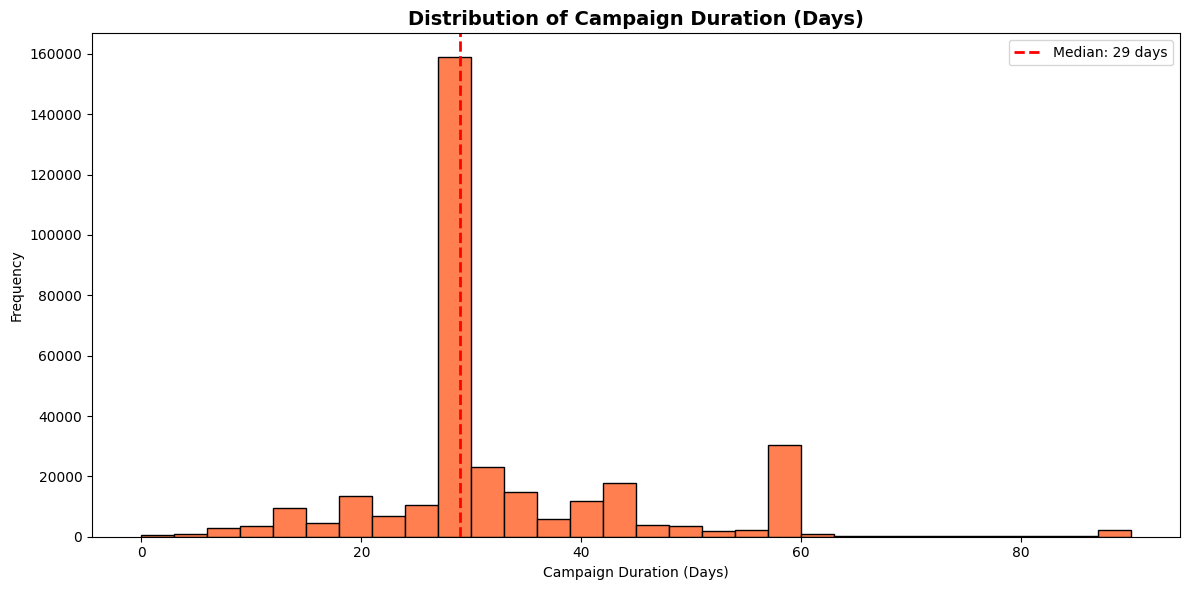

Median campaign duration: 29 days
Mean campaign duration: 33.0 days


In [28]:
# 8. Campaign Duration Distribution
df_duration = df_ks.dropna(subset=['duration_days'])
df_duration_clean = df_duration[
    (df_duration['duration_days'] >= 0) & 
    (df_duration['duration_days'] <= 90)
]

plt.figure(figsize=(12, 6))
plt.hist(df_duration_clean['duration_days'], bins=30, color='coral', edgecolor='black')
plt.title('Distribution of Campaign Duration (Days)', fontsize=14, fontweight='bold')
plt.xlabel('Campaign Duration (Days)')
plt.ylabel('Frequency')
plt.axvline(df_duration_clean['duration_days'].median(), 
            color='red', linestyle='--', linewidth=2, label=f'Median: {df_duration_clean["duration_days"].median():.0f} days')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Median campaign duration: {df_duration_clean['duration_days'].median():.0f} days")
print(f"Mean campaign duration: {df_duration_clean['duration_days'].mean():.1f} days")